# Example: Portfolio Optimization with ESG constraints

**Key Modifications:**
- **Data Preparation**: Sustainability data is fetched, and the filtered list of stocks is created based on the specified ESG thresholds.
- **Portfolio Calculation**: The code calculates optimal portfolios and efficient frontiers for both the original and ESG-filtered sets of stocks.
- **Plotting** with `rp.plot_frontier`:
    - The efficient frontier of the original portfolio is plotted with `rp.plot_frontier` using specified parameters.
    - The filtered portfolio's frontier is added to the same plot using a distinct colour.
    - **Combined Plot**: Both frontiers are plotted on the same graph, allowing for direct visual comparison.

In [3]:
from datetime import datetime, timedelta  # needed for date and time operations and date and time maths
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import pandas as pd
pd.options.display.float_format = '{:.4}'.format  # display numeric values in Pandas up to 4 decimal points only

import yfinance as yf  # for data download from YahooFinance
import warnings  # manage Python warnings (to mute and/or ignore)
warnings.filterwarnings("ignore")

import riskfolio as rp

In [5]:
# Select stocks by specifying tickers of assets
assets = ['DELL', 'ABNB', 'PANW', 'BKNG', 'UBER', 'IBM', 'SCCO', 'ADBE',
          'NFLX', 'SAP', 'TXN', 'ORCL', 'TTD', 'MU', 'PYPL', 'INTC',
          'GOOG', 'MSFT', 'NVDA', 'AMZN', 'META', 'TSLA', 'AAPL', 'AMD', 'CRM']

# Select the time period for analysis
start = '2020-01-01'
end = '2024-07-26'

# Downloading data
data = yf.download(assets, start=start, end=end)
data = data.loc[:, ('Adj Close', slice(None))]
data.columns = assets

# Calculating returns
Y = data[assets].pct_change().dropna()

[*********************100%***********************]  25 of 25 completed


In [11]:
# Fetching sustainability scores for the stocks
sustainability_data = []

for stock in assets:
    try:
        ticker = yf.Ticker(stock)
        sustainability = ticker.sustainability
        environment_score = sustainability.loc['environmentScore'].values[0]
        social_score = sustainability.loc['socialScore'].values[0]
        governance_score = sustainability.loc['governanceScore'].values[0]
        sustainability_data.append([stock, environment_score, social_score, governance_score])
    except:
        # If data is missing or not available, append None values
        sustainability_data.append([stock, None, None, None])

# Convert sustainability data to a DataFrame
sustainability_df = pd.DataFrame(sustainability_data, columns=['Stock', 'Env_Score', 'Soc_Score', 'Gov_Score'])

404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/ABNB?modules=esgScores&corsDomain=finance.yahoo.com&formatted=false&symbol=ABNB&crumb=ZYYolhBweMw
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/UBER?modules=esgScores&corsDomain=finance.yahoo.com&formatted=false&symbol=UBER&crumb=ZYYolhBweMw
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/SAP?modules=esgScores&corsDomain=finance.yahoo.com&formatted=false&symbol=SAP&crumb=ZYYolhBweMw
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/TTD?modules=esgScores&corsDomain=finance.yahoo.com&formatted=false&symbol=TTD&crumb=ZYYolhBweMw
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/GOOG?modules=esgScores&corsDomain=finance.yahoo.com&formatted=false&symbol=GOOG&crumb=ZYYolhBweMw
404 Client Error: Not Found for url: ht

In [13]:
sustainability_df

,Stock,Env_Score,Soc_Score,Gov_Score
0,DELL,0.71,8.41,7.54
1,ABNB,NaN,NaN,NaN
2,PANW,0.7,7.62,5.6
3,BKNG,0.98,10.13,8.13
4,UBER,NaN,NaN,NaN
5,IBM,1.78,6.22,6.14
6,SCCO,12.89,8.74,5.87
7,ADBE,1.94,5.99,5.15
8,NFLX,0.09,7.31,9.01
9,SAP,NaN,NaN,NaN


In [81]:
# Define ESG thresholds (adjust these thresholds as needed)
env_threshold = 8
soc_threshold = 7
gov_threshold = 8

# Filter stocks based on ESG criteria
filtered_stocks = sustainability_df[
    (sustainability_df['Env_Score'] < env_threshold) &
    (sustainability_df['Soc_Score'] < soc_threshold) &
    (sustainability_df['Gov_Score'] < gov_threshold)
]['Stock'].tolist()

print(filtered_stocks)

['IBM', 'ADBE', 'TXN', 'MU', 'NVDA']


In [50]:
# Building the portfolio object
port = rp.Portfolio(returns=Y)

# Calculating optimal portfolio for the original set of stocks
method_mu = 'hist'
method_cov = 'hist'
port.assets_stats(method_mu=method_mu, method_cov=method_cov)

model = 'Classic'
rm = 'MV'
obj = 'Sharpe'
rf = 0
l = 0
hist = True

w = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)
points = 50

# Calculate efficient frontier for the original set of stocks
frontier = port.efficient_frontier(model=model, rm=rm, points=points, rf=rf, hist=hist)

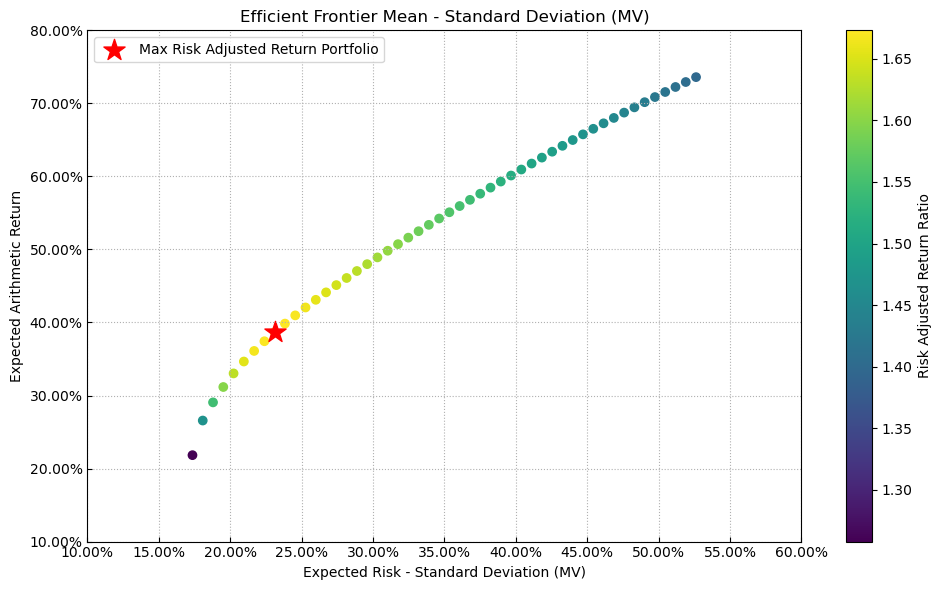

In [51]:
label = 'Max Risk Adjusted Return Portfolio' # Title of point
mu = port.mu # Expected returns
cov = port.cov # Covariance matrix
returns = port.returns # Returns of the assets

ax = rp.plot_frontier(w_frontier=frontier, mu=mu, cov=cov, returns=returns, rm=rm,
                      rf=rf, alpha=0.05, cmap='viridis', w=w, label=label,
                      marker='*', s=16, c='r', height=6, width=10, t_factor=252, ax=None)

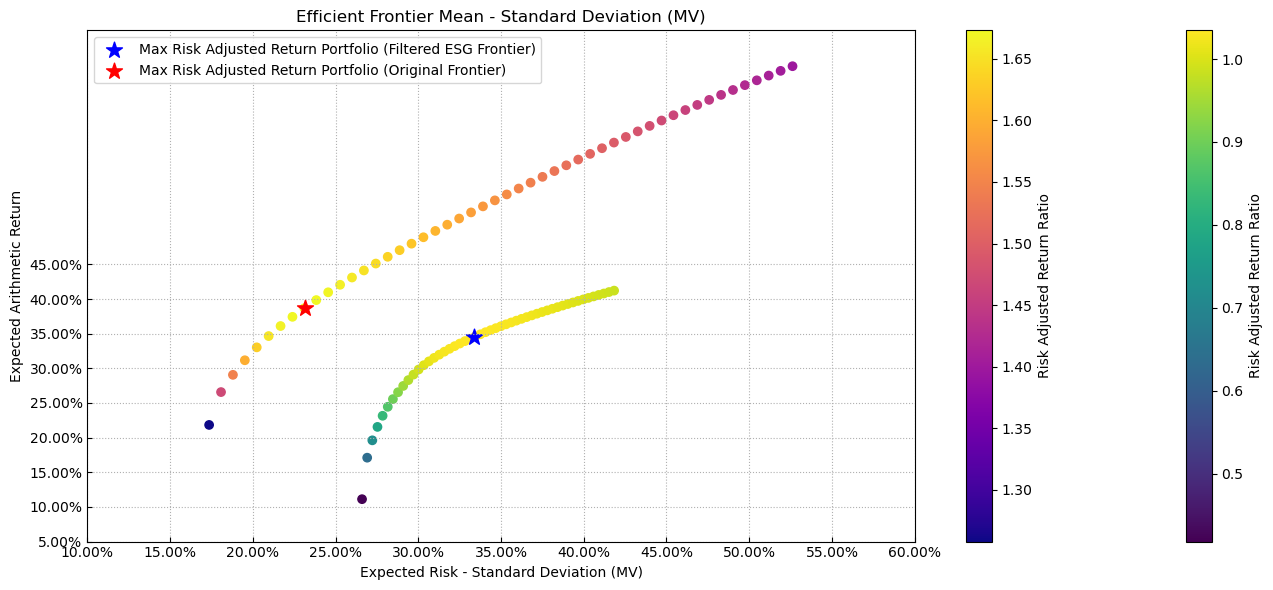

In [85]:
# If filtered stocks are available, calculate the second frontier
if filtered_stocks:
    # Subset the returns data to include only filtered stocks
    Y_filtered = Y[filtered_stocks]

    # Building the portfolio object for the filtered stocks
    port_filtered = rp.Portfolio(returns=Y_filtered)

    # Calculating optimal portfolio for the filtered set of stocks
    port_filtered.assets_stats(method_mu=method_mu, method_cov=method_cov)
    w_filtered = port_filtered.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)

    # Calculate efficient frontier for the filtered set of stocks
    frontier_filtered = port_filtered.efficient_frontier(model=model, rm=rm, points=points, rf=rf, hist=hist)

    # Plotting both efficient frontiers using rp.plot_frontier
    ax = rp.plot_frontier(w_frontier=frontier_filtered, 
                     mu=port_filtered.mu, 
                     cov=port_filtered.cov, 
                     returns=Y_filtered, 
                     rm=rm, 
                     rf=rf, 
                     alpha=0.05, 
                     cmap='viridis', 
                     w=w_filtered, 
                     label='Max Risk Adjusted Return Portfolio (Filtered ESG Frontier)', 
                     marker='*', 
                     s=12, 
                     c='b', 
                     height=6, 
                     width=14, 
                     t_factor=252, 
                     ax=None)
    
    # Add the second frontier to the same plot
    # This will be the original, or unconstrained portfolio frontier. Why?
    rp.plot_frontier(w_frontier=frontier, 
                          mu=port.mu, 
                          cov=port.cov, 
                          returns=Y, 
                          rm=rm, 
                          rf=rf, 
                          alpha=0.05, 
                          cmap='plasma', 
                          w=w, 
                          label='Max Risk Adjusted Return Portfolio (Original Frontier)', 
                          marker='*', 
                          s=12, 
                          c='r', 
                          height=6, 
                          width=14, 
                          t_factor=252, 
                          ax=ax)
else:
    print("No stocks meet the specified ESG criteria.")